<!--TABLE OF CONTENTS-->
Contents:
- [Data Preprocessing](#Data-Preprocessing)
  - [Data scaling](#Data-scaling)
  - [Categorical variables](#Categorical-variables)
    - [One-hot encoding](#One-hot-encoding)
      - [Method 1](#Method-1)
      - [Method 2](#Method-2)
    - [Ordinal encoding](#Ordinal-encoding)
    - [Target Encoding](#Target-Encoding)
  - [Multiple column transformations](#Multiple-column-transformations)
- [Cross validation and Hyperparameter tuning](#Cross-validation-and-Hyperparameter-tuning)
  - [Grid search](#Grid-search)
  - [Randomized search](#Randomized-search)
  - [Successive Halving search](#Successive-Halving-search)
  - [Other libraries for hyperparameter tuning](#Other-libraries-for-hyperparameter-tuning)
  - [Practice question](#Practice-question)
- [Note](#Note)
- [Algorithm chains and pipelines](#Algorithm-chains-and-pipelines)
  - [Building Pipelines](#Building-Pipelines)
  - [The General Pipeline Interface](#The-General-Pipeline-Interface)
  - [Pipeline and ColumnTransformer](#Pipeline-and-ColumnTransformer)
  - [Grid-Searching Which Model To Use](#Grid-Searching-Which-Model-To-Use)
- [Splitting data in cross-validation](#Splitting-data-in-cross-validation)

# Data Preprocessing

The following exercise is adapted from Chapter 4 of the book *Introduction to Machine Learning with Python*, by Andreas C. Müller, Sarah Guido.

Regardless of the types of features our data consists of, how we represent them can have an enormous effect on the performance of machine learning models. The question of how to represent our data best for a particular application is known as feature engineering, and it is one of the main tasks of data scientists trying to solve real-world problems. Representing the data in the right way can have a bigger influence on the performance of a supervised model than the exact parameters we choose.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.inspection import DecisionBoundaryDisplay

## Data scaling
Some algorithms are very sensitive to the scaling of the data. 
Therefore, a common practice is to adjust the features so that the data representation is more suitable for these algorithms.
Let's visualize two different scaling techniques: normalization and standardization.
First, let's generate a small synthetic dataset with sklearn's *make_blobs()*.

Text(0.5, 1.0, 'our dataset')

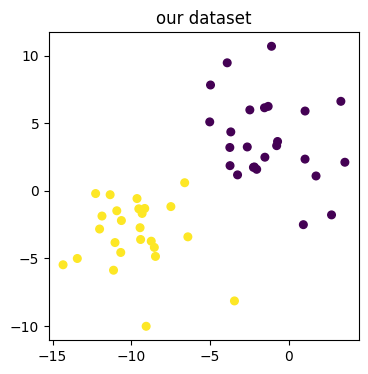

In [7]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=1, cluster_std=3)
plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], s=30, c=y) 
plt.title("our dataset")

The first feature (the x-axis value) is between -15 and 3. The second feature (the y-axis value) is between -10 and 10.
Now, let's scale the data with two different scalers *MinMax* (performs normalization) and *StandardScaler* (performs standardization).

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
X_minmax = minmax_scaler.fit_transform(X)
X_standard = standard_scaler.fit_transform(X)

Now, let's see the difference:

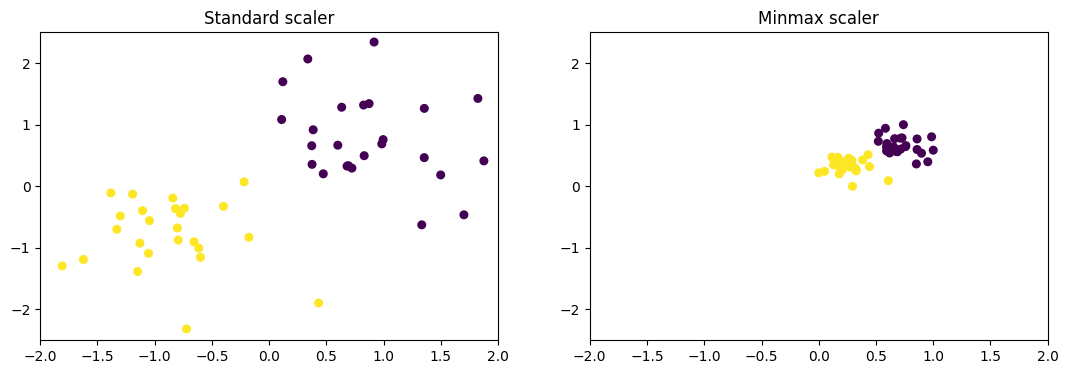

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].set_title("Standard scaler")
ax[0].scatter(X_standard[:, 0], X_standard[:, 1], s=30, c=y)
ax[0].axis([-2, 2, -2.5, 2.5])

ax[1].set_title("Minmax scaler")
ax[1].scatter(X_minmax[:, 0], X_minmax[:, 1], s=30, c=y )
ax[1].axis([-2, 2, -2.5, 2.5]);


The *StandardScaler* in *sklearn* ensures that for each feature the mean is 0 and the variance is 1, bringing all features to the same magnitude. However, this scaling does not ensure any particular minimum and maximum values for the features. 

The *MinMaxScaler*, on the other hand, shifts the data such that all features are exactly between 0 and 1. For the two-dimensional dataset this means all of the data is contained within the rectangle created by the x-axis between 0 and 1 and the y-axis between 0 and 1.

Previously, we have mentioned that it is important that we should fit the scaler only on the training data and transform the test data. This way we avoid any data leakage.
Now, let's also demonstrate why should we apply the same transformation to the training set and the test set for the supervised model.

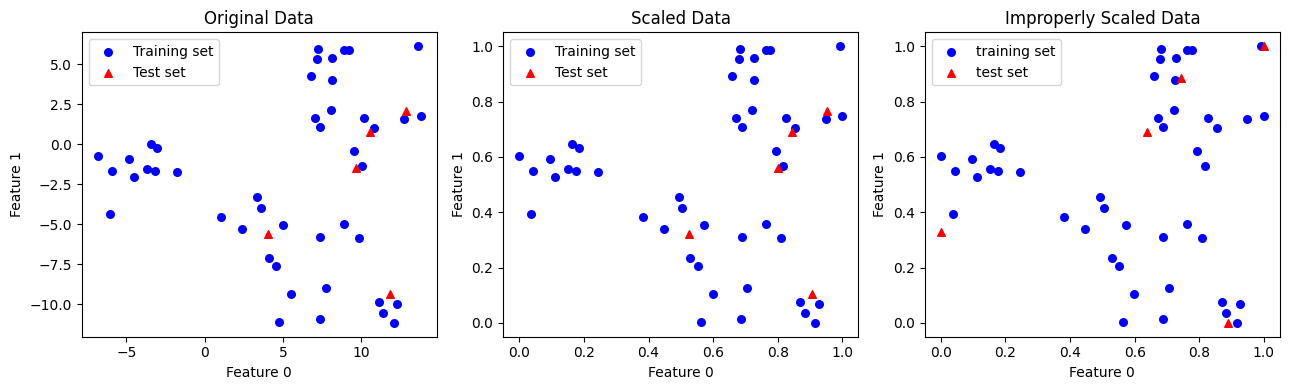

In [14]:
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

fig, ax = plt.subplots(1, 3, figsize=(13, 4))
ax[0].scatter(X_train[:, 0], X_train[:, 1], label="Training set", s=30, c = 'blue')
ax[0].scatter(X_test[:, 0], X_test[:, 1], marker='^', label="Test set", s=30,c = 'red')
ax[0].legend(loc='upper left')
ax[0].set_title("Original Data")

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# visualize the properly scaled data
ax[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], label="Training set", s=30, c = 'blue')
ax[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^', label="Test set", s=30,c = 'red')
ax[1].legend(loc='upper left')
ax[1].set_title("Scaled Data")

# rescale the test set separately
# so test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only.
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
ax[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], label="training set", s=30, c = 'blue')
ax[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1], marker='^',  label="test set", s=30,c = 'red')
ax[2].legend(loc='upper left')
ax[2].set_title("Improperly Scaled Data")

for axi in ax:
    axi.set_xlabel("Feature 0")
    axi.set_ylabel("Feature 1")
fig.tight_layout()

The first subplot is an unscaled two-dimensional dataset, with the training set shown as blue circles and the test set shown as red triangles. The second subplot is the same data, but scaled using the *MinMaxScaler*. Here, we called `fit` on the training set, and then called `transform` on the training and test sets. We can see that the dataset in the second subplot looks identical to the first; only the ticks on the axes have changed. Now all the features are between 0 and 1. We can also see that the minimum and maximum feature values for the test data (the triangles) are not 0 and 1.

The third subplot shows what would happen if we scaled the training set and test set separately. In this case, the minimum and maximum feature values for both the training and the test set are 0 and 1. But now the dataset looks different. The test points moved, as they were scaled differently. We changed the arrangement of the data in an arbitrary way. Clearly this is not what we want to do. Hence, **we should use `fit` on the training set only, and then `transform` on the training and test sets**.

## Categorical variables

For this part of the exercise, we will use the dataset of adult incomes in the United States, derived from the 1994 census database. The task of the dataset is to predict whether a worker has an income of over 50,000 or under 50,000.
Place the downloaded csv file *census_data* in the same directory as your notebook and import it.



In [18]:
data = pd.read_csv('census_data.csv')
# For illustration purposes, we will only select some of the columns
data = data[['age', 'workclass', 'education',  'capital-gain-category', 'hours-per-week', 'occupation', 'income']]
data.head()

age         workclass  education capital-gain-category  hours-per-week  \
0   39         State-gov  Bachelors                  cat2              40   
1   50  Self-emp-not-inc  Bachelors                  cat1              13   
2   38           Private    HS-grad                  cat1              40   
3   53           Private       11th                  cat1              40   
4   28           Private  Bachelors                  cat1              40   

          occupation income  
0       Adm-clerical  <=50K  
1    Exec-managerial  <=50K  
2  Handlers-cleaners  <=50K  
3  Handlers-cleaners  <=50K  
4     Prof-specialty  <=50K

In [19]:
data.shape

(32561, 7)

In [20]:
data.dtypes

age                       int64
workclass                object
education                object
capital-gain-category    object
hours-per-week            int64
occupation               object
income                   object
dtype: object

The *workclass*, *education*, *	capital-gain-category*, and *occupation* features are categorical features. All of them come from a fixed list of possible values, as opposed to a range, and denote a qualitative property, as opposed to a quantity. In our example, target variable is income, and it is also categorical.

### One-hot encoding

By far the most common way to represent categorical variables is using the one-hot-encoding or one-out-of-N encoding, also known as dummy variables. The idea behind dummy variables is to replace a categorical variable with one or more new features that can have the values 0 and 1. We can represent any number of categories by introducing one new feature per category, as described here. In general, this encoding works well if there are only a few levels.
For illustration purposes, we will do one hot encoding for all categorical features, even though education is ordinal, as the values it can take can be ordered.

Let's see the values that the *workclass* feature can take.

In [25]:
data.workclass.value_counts()

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

#### Method 1

Let's apply pandas function *get_dummies* to do one hot encoding.

In [28]:
data_dummies = pd.get_dummies(data)
print(data.shape)
print(data_dummies.shape)
print(data_dummies.columns)
print(data_dummies.dtypes)

(32561, 7)
(32561, 48)
Index(['age', 'hours-per-week', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_10th',
       'education_11th', 'education_12th', 'education_1st-4th',
       'education_5th-6th', 'education_7th-8th', 'education_9th',
       'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'capital-gain-category_cat1',
       'capital-gain-category_cat2', 'capital-gain-category_cat3',
       'capital-gain-category_cat4', 'occupation_?', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_H

We can see that the continuous features *age* and *hours-per-week* were not touched, while the categorical features were expanded into one new feature for each possible value. The *get_dummies* function in pandas treats all numbers as continuous and will not create dummy variables for them. If we have a categorical feature with values as numbers, we should then explicitely list it for dummy coding.

Let's expand the output display for pandas, such that all the columns are shown when we print the dataframe. By default, not all columns will be displayed.

In [31]:
pd.set_option('display.max_columns', None)

In [32]:
data_dummies.head()

age  hours-per-week  workclass_?  workclass_Federal-gov  \
0   39              40        False                  False   
1   50              13        False                  False   
2   38              40        False                  False   
3   53              40        False                  False   
4   28              40        False                  False   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                False                   False              False   
1                False                   False              False   
2                False                   False               True   
3                False                   False               True   
4                False                   False               True   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  \
0                   False                       False                 True   
1                   False                        True                False   
2                   False                       False                False   
3                   False                       False                False   
4                   False                       False                False   

   workclass_Without-pay  education_10th  education_11th  education_12th  \
0                  False           False           False           False   
1                  False           False           False           False   
2                  False           False           False           False   
3                  False           False            True           False   
4                  False           False           False           False   

   education_1st-4th  education_5th-6th  education_7th-8th  education_9th  \
0              False              False              False          False   
1              False              False              False          False   
2              False              False              False          False   
3              False              False              False          False   
4              False              False              False          False   

   education_Assoc-acdm  education_Assoc-voc  education_Bachelors  \
0                 False                False                 True   
1                 False                False                 True   
2                 False                False                False   
3                 False                False                False   
4                 False                False                 True   

   education_Doctorate  education_HS-grad  education_Masters  \
0                False              False              False   
1                False              False              False   
2                False               True              False   
3                False              False              False   
4                False              False              False   

   education_Preschool  education_Prof-school  education_Some-college  \
0                False                  False                   False   
1                False                  False                   False   
2                False                  False                   False   
3                False                  False                   False   
4                False                  False                   False   

   capital-gain-category_cat1  capital-gain-category_cat2  \
0                       False                        True   
1                        True                       False   
2                        True                       False   
3                        True                       False   
4                        True                       False   

   capital-gain-category_cat3  capital-gain-category_cat4  occupation_?  \
0                       False                       False         False   
1                       False                       False         Fals

In this example, we called *get_dummies* on a DataFrame containing both the training and the test data. This is important to ensure categorical values are represented in the same way in the training set and the test set. 
We could have done it separetely, but in that case we would need to ensure that both datasets contain the same categories for all features.

#### Method 2

*Sklearn* has also a function for one-hot encoding. *OneHotEncoder* assumes all features are categorical.

In [36]:
from sklearn.preprocessing import OneHotEncoder

Let us select only categorical features using `select_dtypes` method which returns a subset of the DataFrame’s columns based on the column dtypes. We can define with *include* or *exclude* a list of data types to be included or excluded.

In [38]:
X=data.drop(columns='income')
y=data['income']
categorical=X.select_dtypes(exclude='number').columns
categorical

Index(['workclass', 'education', 'capital-gain-category', 'occupation'], dtype='object')

In [39]:
numerical= X.select_dtypes(include='number').columns
numerical

Index(['age', 'hours-per-week'], dtype='object')

We can now quickly visualize the different values that each categorical variable can take:

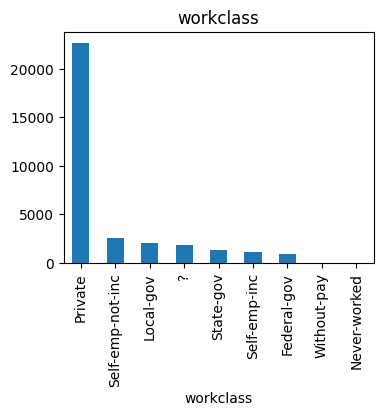

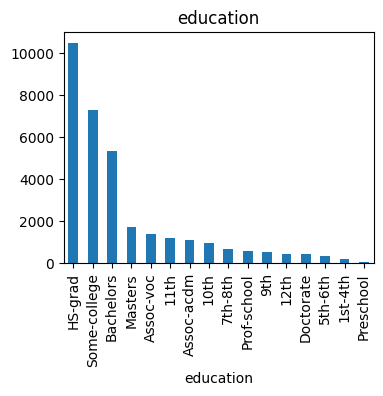

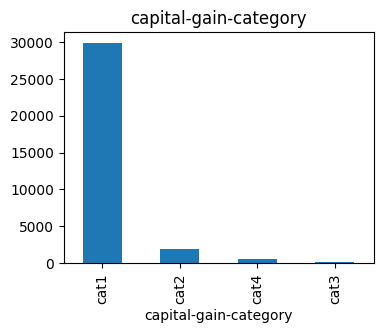

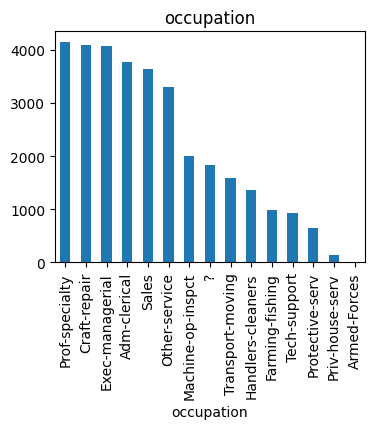

In [41]:
for  categorical_variable in categorical:
    X[categorical_variable].value_counts().plot(kind='bar', figsize=(4,3), title=categorical_variable)
    plt.show()

*OneHotEncoder* has a parameter *drop* with which we can specify whether we want to drop one of the dummy variables in order to avoid collinearity.  We could do this with *OneHotEncoder(drop ='first')*.  Note that this is useful in situations where perfectly collinear features cause problems, such as when feeding the resulting data into an unregularized linear regression model. (When features are highly correlated, small changes in the data can cause large fluctuations in the regression coefficients, and also it becomes harder to determine the importance of each feature). However, dropping one category breaks the symmetry of the original representation and can therefore induce a bias in downstream models, for instance for penalized linear classification or regression model or decision trees.
Let's fit *OneHotEncoder* to categorical variables only.
We will also change the default value of the parameter *sparse_output* which defines whether the encoder will return a sparse matrix or an array. Since we will later convert the output of the encoder to pandas dataframe, we want the output to be an array.

In [43]:
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe.fit(X[categorical])
ohe.categories_

[array(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['cat1', 'cat2', 'cat3', 'cat4'], dtype=object),
 array(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair',
        'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners',
        'Machine-op-inspct', 'Other-service', 'Priv-house-serv',
        'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support',
        'Transport-moving'], dtype=object)]

The attribute *categories_* lists the categories of each feature determined during fitting (in order of the features in X and corresponding with the output of transform). This includes the category specified in drop (if any).

Now let's do `transform`:

In [46]:
X_cat= ohe.transform(X[categorical])
encoder_feature_names = ohe.get_feature_names_out(categorical)
encoder_feature_names

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'capital-gain-category_cat2',
       'capital-gain-category_cat3', 'capital-gain-category_cat4',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation

Let's now convert the array to pandas dataframe:

In [48]:
X_cat= pd.DataFrame(X_cat, columns = encoder_feature_names)

Let's now concatenate the transformed categorical with unchanged numerical variables.

In [50]:
X_num = X[numerical]
X_enc = pd.concat([X_num, X_cat], axis = 1)
print(X_enc.shape)

(32561, 42)


Let us now see how the encoded data frame looks like. As we saw we now have 40 columns. 

In [52]:
X_enc.head()

age  hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
0   39              40                    0.0                  0.0   
1   50              13                    0.0                  0.0   
2   38              40                    0.0                  0.0   
3   53              40                    0.0                  0.0   
4   28              40                    0.0                  0.0   

   workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
0                     0.0                0.0                     0.0   
1                     0.0                0.0                     0.0   
2                     0.0                1.0                     0.0   
3                     0.0                1.0                     0.0   
4                     0.0                1.0                     0.0   

   workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  \
0                         0.0                  1.0                    0.0   
1                         1.0                  0.0                    0.0   
2                         0.0                  0.0                    0.0   
3                         0.0                  0.0                    0.0   
4                         0.0                  0.0                    0.0   

   education_11th  education_12th  education_1st-4th  education_5th-6th  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             1.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   

   education_7th-8th  education_9th  education_Assoc-acdm  \
0                0.0            0.0                   0.0   
1                0.0            0.0                   0.0   
2                0.0            0.0                   0.0   
3                0.0            0.0                   0.0   
4                0.0            0.0                   0.0   

   education_Assoc-voc  education_Bachelors  education_Doctorate  \
0                  0.0                  1.0                  0.0   
1                  0.0                  1.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  1.0                  0.0   

   education_HS-grad  education_Masters  education_Preschool  \
0                0.0                0.0                  0.0   
1                0.0                0.0                  0.0   
2                1.0                0.0                  0.0   
3                0.0                0.0                  0.0   
4                0.0                0.0                  0.0   

   education_Prof-school  education_Some-college  capital-gain-category_cat2  \
0                    0.0                     0.0                         1.0   
1                    0.0                     0.0                         0.0   
2                    0.0                     0.0                         0.0   
3                    0.0                     0.0                         0.0   
4                    0.0                     0.0                         0.0   

   capital-gain-category_cat3  capital-gain-category_cat4  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   occupation_Adm-clerical  occupation_Armed-Forces  occupation_Craft-repair  \
0                      1.0                      0.0                      0.0   
1                      0.0                      0.0               

OneHotEncoder supports aggregating infrequent categories into a single output for each feature. The parameters to enable the gathering of infrequent categories are *min_frequency* and *max_categories*.

- *min_frequency* is either an integer greater or equal to 1, or a float in the interval (0, 1). If *min_frequency* is an integer, categories with a cardinality smaller than *min_frequency* will be considered infrequent. If *min_frequency* is a float, categories with a cardinality smaller than this fraction of the total number of samples will be considered infrequent. The default value is 1, which means every category is encoded separately.

- *max_categories* is either None or any integer greater than 1. This parameter sets an upper limit to the number of output features for each input feature. *max_categories* includes the feature that combines infrequent categories.

Now, let's set for our one-hot encoder that if a category appears in less than 1% of all the data, it should be considered infrequent.

In [55]:
ohe_inf = OneHotEncoder(min_frequency=0.01, sparse_output=False)
ohe_inf.fit(X[categorical])
ohe_inf.get_feature_names_out()

array(['workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_infrequent_sklearn', 'education_10th', 'education_11th',
       'education_12th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Prof-school',
       'education_Some-college', 'education_infrequent_sklearn',
       'capital-gain-category_cat1', 'capital-gain-category_cat2',
       'capital-gain-category_cat4',
       'capital-gain-category_infrequent_sklearn', 'occupation_?',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occup

We see from the previous output that for the feature occupation we have now a category called 'occupation_infrequent_sklearn'. We can check which categories are aggregated in this category:

In [57]:
ohe_inf.infrequent_categories_

[array(['Never-worked', 'Without-pay'], dtype=object),
 array(['1st-4th', 'Preschool'], dtype=object),
 array(['cat3'], dtype=object),
 array(['Armed-Forces', 'Priv-house-serv'], dtype=object)]

We see that two categories 'Armed-Forces' and 'Priv-house-serv' are grouped. Checking the presence of these categories in the data we can confirm that it is less than 1%.

In [59]:
X['occupation'].value_counts(normalize=True)

occupation
Prof-specialty       0.127146
Craft-repair         0.125887
Exec-managerial      0.124873
Adm-clerical         0.115783
Sales                0.112097
Other-service        0.101195
Machine-op-inspct    0.061485
?                    0.056601
Transport-moving     0.049046
Handlers-cleaners    0.042075
Farming-fishing      0.030527
Tech-support         0.028500
Protective-serv      0.019932
Priv-house-serv      0.004576
Armed-Forces         0.000276
Name: proportion, dtype: float64

These levels were grouped together not because they are similar, but because we don't really have enough data to say much about them.

If we fitted the *OneHotEncoder* on the training data, as we should do, if some category is very rare, it might appear only when we transform test data. The behavior for this case is handled with the parameter *handle_unknown*:
- error: This is the default behavior, and an error is raised if an unknown category is present during transform.
- ignore: When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. This means that unknown categories will have the same mapping as the dropped category. For this case, we should not drop any category with the *drop* parameter (as the dropped category is represented with all the zeros of the dummy variables). 
- infrequent_if_exist: When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. 

### Ordinal encoding

Categorical ordinal variables have categories that follow a logical ordering. Some examples of ordinal data include:
- Socioeconomic status (low income, middle income or high income)
- Education level (high school, bachelor’s degree, master’s degree or PhD)
- Satisfaction rating (extremely dislike, dislike, neutral, like or extremely like).

Ordinal variables are encoded using scikit-learn *OrdinalEncoder*. In order to use *OrdinalEncoder*, we have to first specify the order in which we would like to encode our ordinal variable. In our case let's encode education level with ordinal encoder (let's assume some ranking between the education levels), and capital-gain-category.

In [64]:
from sklearn.preprocessing import OrdinalEncoder

In [65]:
X['education'].value_counts()

education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

In [66]:
X['capital-gain-category'].value_counts()

capital-gain-category
cat1    29849
cat2     1942
cat4      613
cat3      157
Name: count, dtype: int64

In [67]:
categories=[['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Prof-school','Assoc-acdm','Assoc-voc','Some-college','Bachelors','Masters','Doctorate'],
            ['cat1','cat2','cat3','cat4']]
encoder = OrdinalEncoder(categories=categories)
encoder.fit(X[['education','capital-gain-category']] )
encoder.categories_

[array(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
        '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm',
        'Assoc-voc', 'Some-college', 'Bachelors', 'Masters', 'Doctorate'],
       dtype=object),
 array(['cat1', 'cat2', 'cat3', 'cat4'], dtype=object)]

In [68]:
X_enc = X.copy()
X_enc[['education','capital-gain-category']] = encoder.transform(X[['education','capital-gain-category']]  )
X_enc.shape

(32561, 6)

In [69]:
X_enc.head()

age         workclass  education  capital-gain-category  hours-per-week  \
0   39         State-gov       13.0                    1.0              40   
1   50  Self-emp-not-inc       13.0                    0.0              13   
2   38           Private        8.0                    0.0              40   
3   53           Private        6.0                    0.0              40   
4   28           Private       13.0                    0.0              40   

          occupation  
0       Adm-clerical  
1    Exec-managerial  
2  Handlers-cleaners  
3  Handlers-cleaners  
4     Prof-specialty

Note that here we remained with the same number of features as we had initially.

In [71]:
X.shape, X_enc.shape

((32561, 6), (32561, 6))

### Target Encoding

When we have categorical features with high cardinality, using one-hot encoding would inflate the feature space making it more computationally expensive for modeling. A classical example of high cardinality categories are location based such as zip code or region. In this case we can use Target Encoding, where each category is encoded based on the average target values for observations belonging to the category, more specifically the encoding scheme mixes the global target mean with the target mean conditioned on the value of the category.

Let's check again how many categories does each categorical feature have using `nunique()` pandas method:

In [75]:
for categorical_variable in categorical:
    print(f'{categorical_variable} has {X[categorical_variable].nunique()} categories')

workclass has 9 categories
education has 16 categories
capital-gain-category has 4 categories
occupation has 15 categories


Let's see how would we encode workclass and occupation with target encoding.

In [77]:
from  sklearn.preprocessing import TargetEncoder

In [78]:
enc = TargetEncoder(target_type='binary')
X_enc = X.copy()
X_enc[['workclass','occupation']] = enc.fit_transform(X[['workclass','occupation']], y)
X_enc.shape

(32561, 6)

We can check what are the values that the categories were mapped to with the following: For feature i, encodings_[i] are the encodings matching the categories listed in categories_[i].

In [80]:
enc.categories_

[array(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 array(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair',
        'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners',
        'Machine-op-inspct', 'Other-service', 'Priv-house-serv',
        'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support',
        'Transport-moving'], dtype=object)]

In [81]:
enc.encodings_

[array([0.10406847, 0.38626183, 0.29476285, 0.        , 0.21867381,
        0.55696537, 0.28490785, 0.27193089, 0.        ]),
 array([0.10367319, 0.13450071, 0.11845551, 0.22664396, 0.48393209,
        0.11576456, 0.06281553, 0.12490973, 0.04159133, 0.00676869,
        0.44896578, 0.32495995, 0.26930666, 0.30487686, 0.20039788])]

The method *fit_transform* internally relies on a cross fitting scheme to prevent target information from leaking into the train. Below is a diagram this process, but we will describe cross validation in more detail in the next section of this Notebook.

<div>
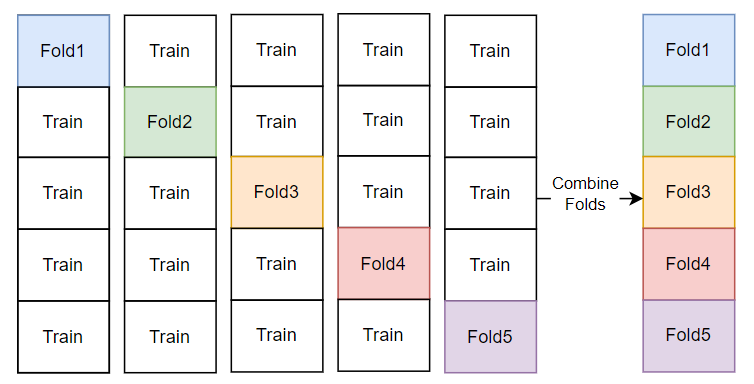
</div>

## Multiple column transformations

What if we wanted to scale some numerical features, encode separately nominal and separately ordinal categorical features? So far, we have done column transformation steps separately.
It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. `sklearn` has `ColumnTransformer` for this purpose. Let's use it to apply all the transformations: 

In [85]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([
    ('scaling', MinMaxScaler(), ['age', 'hours-per-week']),
    ('one_hot', OneHotEncoder(sparse_output=False, drop='first', 
                              min_frequency=0.01, handle_unknown='infrequent_if_exist' ), ['workclass']),
    ('target_enc', TargetEncoder(target_type='binary'), ['occupation']),
    ('ordinal', OrdinalEncoder(categories=categories), ['education','capital-gain-category'] )
], remainder='passthrough')


The constructor of `ColumnTransfmer` requires a list of tuples, where each tuple contains a name of the transformation, user defined, a transformer and a list of names (or indices) of columns
that the transformer should be applied to. In this example, we specify that the numerical
columns should be transformed using the `MinMaxScaler`, that nominal feature workclass is encoded with `OneHotEncoder`, feature occupation will be encoded with `TargetEncoder` and the ordinal features with `OrdinalEncoder`. (We would also need to scale the ordinal encoded feature, but for now, we will ignore this step.)

Here we listed all the columns in the dataframe, as we wished to transform all of them. But we could have had a feature which we did not need to process additionally. By default, only the specified columns in transformers are transformed and combined in the output, and the non-specified columns are dropped. We can change the default behaviour, by specifying the parameter *remainder='passthrough'*, and with this, all remaining columns that were not specified in transformers, but present in the data passed to fit will be automatically passed through.

The default configuration for displaying a `ColumnTransformer` is 'text' where set_config(display='text'). To visualize the diagram in the notebook, use can use `set_config(display='diagram')` and then output the `ColumnTransformer` object.

In [89]:
from sklearn import set_config
set_config(display="diagram")
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', MinMaxScaler(),
                                 ['age', 'hours-per-week']),
                                ('one_hot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist',
                                               min_frequency=0.01,
                                               sparse_output=False),
                                 ['workclass']),
                                ('target_enc',
                                 TargetEncoder(target_type='binary'),
                                 ['occupation']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th',
                                                             '5th-6th',
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Prof-school',
                                                             'Assoc-acdm',
                                                             'Assoc-voc',
                                                             'Some-college',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Doctorate'],
                                                            ['cat1', 'cat2',
                                                             'cat3', 'cat4']]),
                                 ['education', 'capital-gain-category'])])

Now, let's split our data into train and test. Then, let's fit our *ColumnTransformer* to our train data and then transform it.

In [91]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ct.fit(X_train, y_train)
X_train_trans = ct.transform(X_train)
X_train_trans.shape

(24420, 12)

We can see that we obtained 12 features: 2 numerical, 2 ordinal and (9-2) dummy features for workclass, here we did not drop one dummy variable, as we will be using a regularized model later, but we grouped 2 infrequent categories together, and 1 target encoded feature, occupation. Let's see the list of the features for our transformed dataset, using *get_feature_names_out()* method on the fitted ColumnTransformer.

In [93]:
ct.get_feature_names_out()

array(['scaling__age', 'scaling__hours-per-week',
       'one_hot__workclass_Federal-gov', 'one_hot__workclass_Local-gov',
       'one_hot__workclass_Private', 'one_hot__workclass_Self-emp-inc',
       'one_hot__workclass_Self-emp-not-inc',
       'one_hot__workclass_State-gov',
       'one_hot__workclass_infrequent_sklearn', 'target_enc__occupation',
       'ordinal__education', 'ordinal__capital-gain-category'],
      dtype=object)

Let's access the one hot encoder inside the column transformer using the attribute `named_transformers_` to check that we did indeed end up with two categories grouped in *'one_hot__workclass_infrequent_sklearn'* category:

In [95]:
ct.named_transformers_['one_hot'].infrequent_categories_

[array(['Never-worked', 'Without-pay'], dtype=object)]

Note that we fitted the column transformer with X and y. Here we needed y only because we used traget encoding. If we did not use it, we would fit with only X.

Now, we can build a *LogisticRegression* model. Since we transformed our train data, the same transformations must be done for the test data. As before, we only apply the *transform* on the test data.

In [98]:
from sklearn.metrics import classification_report
logreg = LogisticRegression(solver="liblinear", random_state=42)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
y_pred=logreg.predict(X_test_trans)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.82      0.94      0.88      6159
        >50K       0.66      0.38      0.48      1982

    accuracy                           0.80      8141
   macro avg       0.74      0.66      0.68      8141
weighted avg       0.78      0.80      0.78      8141



# Cross validation and Hyperparameter tuning

To evaluate our supervised models, so far we have split our dataset into a training set and a test set using the `train_test_split` function, built a model on the training set by calling the `fit` method, and evaluated it on the test set using a variety of metrics.
Note, the reason we split our data into training and test sets is that we are interested in measuring how well our model *generalizes* to new, previously unseen data. We are not interested in how well our model fit the training set, but rather in how
well it can make predictions for data that was not observed during training.

Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set. In cross-validation, the data is instead split repeatedly and multiple models are trained. The
most commonly used version of cross-validation is k-fold cross-validation, where k is a user-specified number, usually 5 or 10. When performing five-fold cross-validation, the data is first partitioned into five parts of (approximately) equal size, called folds.
Next, a sequence of models is trained. The first model is trained using the first fold as the test set, and the remaining folds (2–5) are used as the training set. The model is built using the data in folds 2–5, and then the accuracy is evaluated on fold 1. Then
another model is built, this time using fold 2 as the test set and the data in folds 1, 3, 4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets. For each of these five splits of the data into training and test sets, we compute the accuracy. In the end, we have collected five accuracy values.  Usually, the first fifth of the data is the first fold, the second fifth of the data is the second fold, and so on. (Note: this is not valid for time series.)

Let's now import the iris dataset, using the parameter *return_X_y=True* to return the features and label directly. We will also shuffle the data, since the data is sorted by labels, and we want to have data instances of different labels in each fold. Later in this notebook, we will return to this and discuss better approach to achieve this, but for now, we will just shuffle the data.

In [103]:
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
X, y = load_iris(return_X_y=True)
X, y = shuffle(X, y, random_state=0)

Let's check the distribution of the target variable.

In [105]:
from collections import Counter 
Counter(y)

Counter({2: 50, 1: 50, 0: 50})

Cross-validation is implemented in `sklearn` using the `cross_val_score` function from the `model_selection` module. The parameters of the `cross_val_score` function are the model we want to evaluate, the training data, and the ground-truth labels. By default, the score computed at each CV iteration is the score method of the estimator. For logistic regression this is accuracy. The following link gives a list of all the possible options that scoring parameter of `cross_val` can take: \
https://scikit-learn.org/stable/modules/model_evaluation.html  \
If we wanted to use another metric, we could pass another vale to `scoring` parameter, for example `scoring='f1'`. For now, let's keep the default option.

Let’s evaluate LogisticRegression on the iris dataset: (we will not do scaling for now).

In [107]:
from sklearn.model_selection import cross_val_score
log_reg = LogisticRegression(solver="liblinear", random_state=42 , max_iter=10000)
scores = cross_val_score(log_reg, X, y)
print(scores)

[1.         0.86666667 0.96666667 0.96666667 0.96666667]


By default, `cross_val_score` performs five-fold cross-validation, returning five
accuracy values. The number of folds can be changed using `cv` parameter.

A common way to summarize the cross-validation accuracy is to compute the mean:


In [110]:
print("Average cross-validation score:", scores.mean() )

Average cross-validation score: 0.9533333333333334


Using the mean cross-validation we can conclude that we expect the model to be around 95% accurate on average. Looking at all five scores produced by the five-fold cross-validation, we can also conclude that there is a relatively high variance in the
accuracy between folds, ranging from 100% accuracy to 86% accuracy. This could imply that the model is very dependent on the particular folds used for training, but it could also just be a consequence of the small size of the dataset.

Note that in cross-validation, for each fold, the process can be done in parallel, so for 5-fold CV, if we have computational resources, we could run 5 processes in parallel. With the parameter `n_jobs`, we could specify the number of jobs (number of concurrent threads or processes) to run in parallel. If this parameter is not specified, it means only 1 job is run at a time, while `n_jobs=-1` means that all available CPUs should be used. However, if the training takes a lot of time, allocating all CPUs to cross-validation will leave us without any resources to do other things on the computer.

To check how many *logical* CPUs we have, we can use `os.cpu_count()`:

In [113]:
import os
os.cpu_count()

8

We have used the default value of the hyperparameter C, which is inverse of regularization strength. However to try to get better model performance, we should try different values. Because hyperparameter tuning is such a common task, there are standard methods in `sklearn` that we can use. We can tune the parameters by using three sets: the training set to build the model, the validation  set to select the parameters of the model, and the test set to evaluate the performance of the selected parameters. 
After selecting the best parameters using the validation set, **we can rebuild a model using the parameter settings we found, but now training on both the training data and the validation data.** This way, we can use as much data as possible to build our model. The performance of the final model is evaluated on the test set.

## Grid search

The most commonly used method is grid search, which basically means trying all possible combinations of the
parameters of interest.

In [117]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
# split train+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=1, test_size=0.3)

In [118]:
print(f'Size of training set: {X_train.shape[0]}, size of validation set: {X_val.shape[0]} size of test set {X_test.shape[0]}')

Size of training set: 84, size of validation set: 36 size of test set 30


In [119]:
best_score = 0
for penalty_value in ['l1','l2']:
    for C_value in [0.001, 0.01, 0.1, 1, 10]:
        # for each combination of parameters, train a model
        log_reg = LogisticRegression(solver="liblinear", random_state=42, penalty=penalty_value, C=C_value, max_iter=10000)
        log_reg.fit(X_train, y_train)
        # evaluate the model on the validation set
        score = log_reg.score(X_val, y_val)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C_value, 'penalty': penalty_value}
print(best_parameters)

{'C': 10, 'penalty': 'l1'}


In [120]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
log_reg = LogisticRegression(solver="liblinear", random_state=42, penalty=best_parameters['penalty'], C=best_parameters['C'] , max_iter=10000)
log_reg.fit(X_trainval, y_trainval)
test_score = log_reg.score(X_test, y_test)
print('Best score on validation set', best_score)
print("Test set score with best parameters", test_score)

Best score on validation set 0.9722222222222222
Test set score with best parameters 0.9666666666666667


The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy "leak" information from the test set into the model.
Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation.

While the method of splitting the data into a training, a validation, and a test set that
we just saw is workable, and relatively commonly used, it is quite sensitive to how
exactly the data is split. For a better estimate of the generalization performance, instead of
using a single split into a training and a validation set, we can use cross-validation to
evaluate the performance of each parameter combination. 

Because grid search with cross-validation is such a commonly used method to adjust parameters, `sklearn` provides the `GridSearchCV` class, which implements it in the form of an estimator. To use the `GridSearchCV` class, we first need to specify the
parameters we want to search over using a dictionary. `GridSearchCV` will then perform all the necessary model fits. The keys of the dictionary are the names of parameters we want to adjust (as given when constructing the model, in this case, *C* and
*penalty*), and the values are the parameter settings we want to try out. The default metric for evaluation used will be the default score of the estimator, but just like in `cross_val_score`, a different `scoring` metric can be set.

In [124]:
from sklearn.model_selection import GridSearchCV

In [125]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
               'penalty': ['l1','l2']}

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [127]:
print(f'Size of training set: {X_train.shape[0]}, size of test set {X_test.shape[0]}')

Size of training set: 120, size of test set 30


In [128]:
grid_search = GridSearchCV(LogisticRegression(solver="liblinear", random_state=42, max_iter=10000), param_grid, cv=5)

The grid_search object that we created behaves just like a classifier; we can call the standard methods `fit`, `predict`, and `score` on it. However, when we call `fit`, it will run cross-validation for each combination of parameters we specified in the parameter grid. We have 5 different values for *C*, and 2 for *penalty*, giving in total 10 combinations. For each combination 5-fold CV is used, meaning in total 50 models are trained. And here we only have two parameters we want to tune. Hence, when running a grid search over many parameters and on large datasets it can be computationally challenging. One way to speed things up is with parallelization. Since using a particular parameter setting on a particular cross-validation split can be done completely independently from the other parameter settings and models, we can again parallelized just like we mentioned in `cross_val_score`. In GridSearchCV we could also use the parameter `n_jobs` to define how many jobs could be run in parallel.

In [130]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']})

Now that this is fit, we can ask for the best parameters as follows:

In [132]:
grid_search.best_params_

{'C': 10, 'penalty': 'l2'}

The best cross-validation accuracy (the mean accuracy over the different splits for this parameter setting) is stored in `best_score_`:

In [134]:
grid_search.best_score_

0.975

The results of a grid search can be found
in the `cv_results_` attribute, which is a dictionary storing all aspects of the search. We can convert it to a pandas dataframe to view it:

In [136]:
results = pd.DataFrame(grid_search.cv_results_)
results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       0.002927      0.001664         0.003122        0.001338    0.001   
1       0.004115      0.002087         0.003950        0.001974    0.001   
2       0.003439      0.002083         0.001141        0.000825    0.010   

  param_penalty                         params  split0_test_score  \
0            l1  {'C': 0.001, 'penalty': 'l1'}           0.333333   
1            l2  {'C': 0.001, 'penalty': 'l2'}           0.333333   
2            l1   {'C': 0.01, 'penalty': 'l1'}           0.333333   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.333333           0.333333           0.333333           0.333333   
1           0.333333           0.333333           0.291667           0.333333   
2           0.333333           0.333333           0.375000           0.375000   

   mean_test_score  std_test_score  rank_test_score  
0         0.333333        0.000000                9  
1         0.325000        0.016667               10  
2         0.350000        0.020412                8

By default an estimator is retrained using the best found parameters on the whole train dataset. We can access the model with `.best_estimator_` attribute and test its perfromance on the test set:

In [138]:
grid_search.best_estimator_.score(X_test, y_test)

0.9666666666666667

Or we could have just used the score method directly on the grid_search:

In [140]:
grid_search.score(X_test, y_test)

0.9666666666666667

The important thing here is that **we did not use the test set to choose the parameters**, meaning the final test set was only used for the final model evaluation. 

## Randomized search

If we had many different paramenters and many values to evaluate, randomized search would be a better option than grid. In contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by *n_iter*.

In [144]:
from sklearn.model_selection import RandomizedSearchCV

In [145]:
from scipy.stats import loguniform

distributions= { 'C': loguniform(0.0001, 10), 
                 'penalty': ['l1', 'l2']}

Using a loguniform distribution instead of a regular uniform distribution will ensure that in a sufficiently large number of trials, the same number of samples will be drawn from the [0.0001, 0.001] range as, for example, the [1, 10] range.

In [147]:
random_search = RandomizedSearchCV(LogisticRegression(solver="liblinear", random_state=42, max_iter=10000), distributions, cv=5,  n_iter=10, random_state=1)
random_search.fit(X_train, y_train)
random_search.best_params_

{'C': 4.600306804490298, 'penalty': 'l2'}

Running the results with a different seed especially for a small number of iterations might lead to different parameters selected. 

Now we evaluate the performance of the model with the best parameters on the test set:

In [150]:
random_search.score(X_test, y_test)

0.9666666666666667

Just like in `GridSearchCV` we could change the `scoring` method, use parallelization with `n_jobs`, view `cv_results_` and access the model through `best_estimator`.

If we had a large number of parameters,  would me much more practical choice than `GridSearchCV`. However, there are more efficient approached than `RandomizedSearchCV`.

## Successive Halving search

*Sklearn* also provides the *HalvingGridSearchCV* and *HalvingRandomSearchCV* estimators that can be used to search a parameter space using successive halving . Successive halving (SH) is like a tournament among candidate hyperparameter combinations. It is an iterative selection process where all candidates (the hyperparameter combinations) are evaluated with a small amount of resources at the first iteration. Only some of these candidates are selected for the next iteration, which will be allocated more resources. For parameter tuning, the resource is typically the number of training samples, but it can also be an arbitrary numeric parameter.

We can summarize the procedure via the following steps:

1. Draw a large set of candidate configurations (hyperparameter combinations) via random sampling.
2. Train the models (i.e., each set of hyperparameter combinations) with limited resources, for example, a small subset of the training data (as opposed to using the entire training set).
3. Discard the bottom 50 percent (typical value) based on predictive performance.
4. Go back to step 2 with an increased amount of available resources for each of the surviving configurations.

The steps are repeated until only one hyperparameter configuration remains.

In [155]:
from sklearn.experimental import enable_halving_search_cv

In [156]:
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(LogisticRegression(solver="liblinear", random_state=42, max_iter=10000), 
                            param_distributions=distributions, 
# specifies the resource that will be allocated to each candidate configuration during evaluation. 
# In this case, it's set to 'n_samples', indicating that the number of training samples will be used as the resource. 
# Each candidate configuration will be trained and evaluated using a subset of the training data.
                            resource='n_samples', 
# select half of candidates in each iteration % (default is 3, select 1/3 of candidates)                         
                           factor=2, 
# The number of candidate parameters to sample, at the first iteration.
                           n_candidates=10,
                           random_state=1)

hs.fit(X_train, y_train)
hs.best_params_

{'C': 4.600306804490298, 'penalty': 'l2'}

Again, we evaluate the performance of the model with the best parameters on the test set:

In [158]:
hs.score(X_test, y_test)

0.9666666666666667

The `cv_results_` attribute again contains useful information for analyzing the results of a search.

In [160]:
pd.set_option('display.max_columns', None)

In [161]:
results = pd.DataFrame(hs.cv_results_)
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0      0           30       0.004911      0.001739         0.003597   
1      0           30       0.009551      0.006414         0.008887   
2      0           30       0.011571      0.016472         0.004193   
3      0           30       0.006710      0.006244         0.001695   
4      0           30       0.007452      0.003027         0.012958   
5      0           30       0.003607      0.003976         0.005699   
6      0           30       0.004812      0.003195         0.000630   
7      0           30       0.004658      0.001181         0.005618   
8      0           30       0.004179      0.003769         0.004323   
9      0           30       0.008003      0.005219         0.002800   
10     1           60       0.005331      0.007196         0.009976   
11     1           60       0.006290      0.005508         0.004830   
12     1           60       0.006185      0.004579         0.003850   
13     1           60       0.005531      0.005763         0.007023   
14     1           60       0.007699      0.002374         0.003544   
15     2          120       0.007281      0.002673         0.007458   
16     2          120       0.005487      0.003290         0.006534   
17     2          120       0.006314      0.004630         0.002907   

    std_score_time   param_C param_penalty  \
0         0.002706  0.012165            l1   
1         0.011955  4.600307            l2   
2         0.004823  0.003248            l2   
3         0.001438  0.001515            l2   
4         0.010096  0.000854            l2   
5         0.002087  0.223218            l2   
6         0.001260  0.049441            l1   
7         0.004366  0.003684            l1   
8         0.006101  0.001053            l1   
9         0.003768  0.001406            l1   
10        0.009796  0.003684            l1   
11        0.005275  0.001053            l1   
12        0.004312  0.001406            l1   
13        0.005831  0.223218            l2   
14        0.001680  4.600307            l2   
15        0.003215  0.001406            l1   
16        0.005949  0.223218            l2   
17        0.001485  4.600307            l2   

                                           params  split0_test_score  \
0    {'C': 0.012164941464151846, 'penalty': 'l1'}           0.500000   
1       {'C': 4.600306804490298, 'penalty': 'l2'}           0.833333   
2    {'C': 0.003248350345086679, 'penalty': 'l2'}           0.166667   
3   {'C': 0.0015151125123102904, 'penalty': 'l2'}           0.166667   
4   {'C': 0.0008536916958038761, 'penalty': 'l2'}           0.166667   
5       {'C': 0.223218499287176, 'penalty': 'l2'}           0.666667   
6     {'C': 0.04944059287398676, 'penalty': 'l1'}           0.166667   
7   {'C': 0.0036844068804921994, 'penalty': 'l1'}           0.500000   
8    {'C': 0.001052594868979971, 'penalty': 'l1'}           0.500000   
9   {'C': 0.0014056787147388348, 'penalty': 'l1'}           0.500000   
10  {'C': 0.0036844068804921994, 'penalty': 'l1'}           0.333333   
11   {'C': 0.001052594868979971, 'penalty': 'l1'}           0.333333   
12  {'C': 0.0014056787147388348, 'penalty': 'l1'}           0.333333   
13      {'C': 0.223218499287176, 'penalty': 'l2'}           0.750000   
14      {'C': 4.600306804490298, 'penalty': 'l2'}           0.916667   
15  {'C': 0.0014056787147388348, 'penalty': 'l1'}           0.333333   
16      {'C': 0.223218499287176, 'penalty': 'l2'}           0.833333   
17      {'C': 4.600306804490298, 'penalty': 'l2'}           0.958333   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.500000           0.333333           0.333333   
1            1.000000           0.833333           0.666667   
2            0.166667           0.333333           0.166667   
3            0.166667           0.333333           0.166667   
4            0.166667           0.333333           0.166667   
5            0.666667           

From the results we can see that in the first round (iter 0), 10 different hyperparameter combinations were used. Since a factor of 2 was specified, this means only 5 combinations were selected for the next round with double the number of resources, i.e., the number of training data points used increased from 30 to 60. Then, half of these 5 combinations were selected, in our case, this is 3, to go to the next round, and the models were trained on all the samples. Out of those 3 combinations, the one with the highest *mean_test_score* (lowest `rank_test_score`) was selected as the best one.

## Other libraries for hyperparameter tuning

Since hyperparameter tuning is a very important step in modeling, many different approaches and libraries were developed to speed up the model tuning when there are many different parameters to be tuned. Here, we will illustrate one such simple library, `scikit-optimize`, which implements Bayesian optimization, which works by considering the previously seen hyperparameter combinations when determining the next set of hyperparameters to evaluate. Bayesian optimization reduces the number of evaluations needed to identify optimal hyperparameters, making it effective for optimizing complex models.
Let's install the `scikit-optimize` library with:

`pip install scikit-optimize`

Note that when importing this library is referred to as: `skopt`.

In [165]:
from skopt import BayesSearchCV
from skopt.space import Real 

In [166]:
distributions = {
    'penalty': ['l1','l2'],
    'C': Real(low=1e-4, high=10,  prior='log-uniform'),
}

In [167]:
np.int = int
opt = BayesSearchCV(
    LogisticRegression(solver="liblinear", random_state=42, max_iter=10000),
    distributions,
    n_iter=10,
    random_state=1
)

opt.fit(X_train, y_train)

BayesSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42,
                                           solver='liblinear'),
              n_iter=10, random_state=1,
              search_spaces={'C': Real(low=0.0001, high=10, prior='log-uniform', transform='normalize'),
                             'penalty': ['l1', 'l2']})

We can see the best parameters:

In [169]:
opt.best_params_

OrderedDict([('C', 2.4458265756334576), ('penalty', 'l1')])

And, as before, we can access the best model with:

In [171]:
opt.best_estimator_

LogisticRegression(C=2.4458265756334576, max_iter=10000, penalty='l1',
                   random_state=42, solver='liblinear')

In [172]:
opt.score(X_test, y_test)

0.9666666666666667

## Practice question
Using sklearn's  make_regression, generate a toy dataset:

X, y = make_regression(n_samples=100, n_features=10, noise=20,  n_informative=5,  random_state=1), 

split it into train and test. Then use Ridge regression with grid search cross validation to find the value of $\alpha$ that minimizes the mean square error. Then evaluate this model on the test set. Hint: check the `scoring` parameter and the score method  *'neg_root_mean_squared_error'*.

# Note

We have mentioned that no modeling decision should be done on the test dataset, and that we use validation data to make model selection and parameter tuning. Let's think about the preprocessing steps such as scaling. If we can use the `fit` method only on the train dataset, and not the validation dataset, how do we apply CV, without applying `fit` to the testing fold?

Next, we will introduce `pipelines` which will help us with this issue. But without `pipelines`, in the above code, we did not apply the scaling stage before cross validation, even for the regularized models.

# Algorithm chains and pipelines

The following exercise is adapted from Chapter 6 of *Introduction to Machine Learning with Python* by Andreas C. Müller, Sarah Guido.

In this section we will review how to chain together many different processing steps and machine learning models by using *Pipeline* class. 
 
Let's start with an example of using a scaler, before applying a machine learning model, this time to do regression. We will use house price dataset from `sklearn`, and apply Ridge Regression. Before applying the model, we will split the data into train and test, and fit the `MinMax` scaler on the training data, and then transform both the training and the testing data. Note that we are scaling here to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features.

In [178]:
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report

# load the data
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [179]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, random_state=0)
# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


ridge = Ridge(alpha=0.01)
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=0.01)

In [180]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import r2_score

y_pred=ridge.predict(X_test_scaled)
print('Mean squared error:', mean_squared_error(y_test, y_pred))
print('Root mean squared error:', root_mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

Mean squared error: 0.540554646703696
Root mean squared error: 0.7352242152593289
R2:  0.5910622391340353


 For `RidgeRegression` the default scoring is the R2. Hence, if we were only interested in R2, we could have simply used the *score* function:

In [182]:
ridge.score(X_test_scaled, y_test)

0.5910622391340353

Now, let's say we want to find better parameters for the ridge using *GridSearchCV*. 
   
A naive and WRONG approach to doing a grid search with data scaling might look like this:

In [184]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1]  }
grid = GridSearchCV(Ridge(), param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1]},
             scoring='neg_root_mean_squared_error')

Here, we ran the grid search over the parameter of *Ridge* using the scaled data. However, there is a subtle catch in what we just did. When scaling the data, we used ALL the data in the training set to compute the minimum and maximum of the data. We then used the scaled training data to run our grid search using cross-validation. For each split in the cross-validation, some part of the original training set will be declared the training part of the split, and some the test part of the split. The test part is used to measure the performance of a model trained on the training part when applied to new data. However, we already used the information contained in the test part of the split, when scaling the data. 

So, the splits in the cross-validation no longer correctly mirror how new data will look to the modeling process. We already leaked information from these parts of the data into our modeling process. This will lead to overly optimistic results during cross-validation, and possibly the selection of sub-optimal parameters.

To get around this problem, the splitting of the dataset during cross-validation should be done BEFORE doing any pre-processing. Any process that extracts knowledge from the dataset should only ever be learned from the training portion of the dataset, and therefore be contained inside the cross-validation loop.

To achieve this in `sklearn` with the `GridSearchCV` function, we can use the `Pipeline` class. The `Pipeline` class is a class that allows "gluing" together multiple processing steps into a single `sklearn` estimator.

The `Pipeline` class itself has `fit`, `predict`, and `score` methods and behaves just like any other model in `sklearn`. The most common use case of the `Pipeline` class is in chaining pre-processing steps (like scaling of the data) together with a supervised model like a classifier.

## Building Pipelines
 First, we build a pipeline object by providing it with a list of steps. Each step is a tuple containing a name (any string of our choosing) and an instance of an estimator:

In [187]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), 
                 ('ridge',  Ridge(alpha=0.01))])

Just like for `ColumnTransformer`, when the `sklearn` display setting is set to diagram, with `set_config(display='text')`, we can visualize the pipeline. Note that clicking on the diagram below allows us to see the details of each step:

In [189]:
pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.01))])

Here, we created two steps: the first, called "scaler", is an instance of *MinMaxScaler*, and the second, called "ridge", is an instance of *Ridge*. Now, we can fit the pipeline, like any other `sklearn` estimator:

In [191]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.01))])

Here, *pipe.fit* first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the *Ridge* with the scaled data. To evaluate on the test data with the default scoring metric of the regressor, we simply call *pipe.score*:

In [193]:
pipe.score(X_test, y_test)

0.5910622391340353

Calling the `score` method on the pipeline first transforms the test data using the scaler, and then calls the `score` method on the `Ridge` using the scaled test data. As we can see, the result is identical to the one we got from the code by doing the transformations by hand. Using the pipeline, we reduced the code needed for our "preprocessing + classification" process. The main benefit of using the pipeline, however, is that we can now use this single estimator in *GridSearchCV*.

Using a pipeline in a grid search works the same way as using any other estimator. We define a parameter grid to search over, and construct a *GridSearchCV* from the pipeline and the parameter grid. When specifying the parameter grid, there is a slight change, though. We need to specify for each parameter which step of the pipeline it belongs to. The parameter that we want to adjust, *alpha*, is the parameter of *Ridge*, the second step. We gave this step the name "ridge". The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by __ (a double underscore), followed by the parameter name. To search over the *alpha* parameter of "ridge" we therefore have to use "ridge__max_alpha" as the key in the parameter grid dictionary.

We could also use the method `get_params` to see the names of all the parameters of an estimator:

In [196]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.01))],
 'transform_input': None,
 'verbose': False,
 'scaler': MinMaxScaler(),
 'ridge': Ridge(alpha=0.01),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'ridge__alpha': 0.01,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

We can see what parameters of the pipeline that we built can be tuned. Parameters of the scaling step start with *scaler__*, parameters of ridge start with *ridge__*. Note that *scaler* and *ridge* are just names we gave to the steps of the pipeline, we could have given any other name.

Now, let's define the parameters that we wish to tune:

In [199]:
param_grid = {'ridge__alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1]}

In [200]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
y_pred=grid.predict(X_test)

print('Best cross-validation score (negative RMSE): ', grid.best_score_)
print('Test set score: ', grid.score(X_test, y_test))
print('Best parameters: ', grid.best_params_)

Best cross-validation score (negative RMSE):  -0.7243104320018825
Test set score:  -0.7363007117320173
Best parameters:  {'ridge__alpha': 0.1}


In contrast to the grid search we did before, now for each split in the cross-validation, the *MinMaxScaler* is refit with ONLY the training splits and no information is leaked from the test split into the parameter search.

In this case since scaling is used to ensure smooth convergence of the gradient descent, there is not much difference when using the wrong and correct way of scaling. However, in many cases, if data leakage occurs it may actually lead to choosing sub-optimal parameters.

## The General Pipeline Interface
The `Pipeline` class is not restricted to pre-processing and classification or regression, but can, in fact, join any number of estimators together. For example, we could build a pipeline containing feature extraction, feature selection, scaling, and classification, for a total of four steps. Similarly, the last step could clustering instead of classification.

The only requirement for estimators in a pipeline is that all but the last step need to have a `transform` method, so they can produce a new representation of the data that can be used in the next step.

Internally, during the call to `Pipeline.fit`, the pipeline calls `fit` and then `transform` on each step in turn, with the input given by the output of the transform method of the previous step. For the last step in the pipeline, just `fit` is called.

Pipeline is also adjusted for adequate use of sklearn's estimators and transformers. For example, when `TargetEncoder` is a part of a Pipeline and the pipeline is fitted, the pipeline will correctly call `TargetEncoder.fit_transform` and use cross fitting when encoding the training data.

Often, we will want to inspect attributes of one of the steps of the pipeline, say, the coefficients of a linear model. The easiest way to access the steps in a pipeline is via the *named_steps* attribute, which is a dictionary from the step names to the estimators:

In [206]:
pipe = Pipeline( [('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.01))])

We can check the steps of the pipeline:

In [208]:
pipe.steps

[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.01))]

Visualize the pipeline:

In [210]:
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.01))])

Or get pipe parameters:

In [212]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.01))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'ridge': Ridge(alpha=0.01),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'ridge__alpha': 0.01,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

We can access a certain step of the `pipeline`, using `named_steps`:

In [214]:
pipe.named_steps['ridge']

Ridge(alpha=0.01)

Next, we will fit the pipeline with the housing data. Since we wantto pass the feature names to the pipeline, we will convert the numpy array to a dataframe:

In [216]:
X_pipe = pd.DataFrame(housing.data, columns=housing.feature_names)
y_pipe = housing.target

In [217]:
# fit the pipeline defined before to the housing dataset
pipe.fit(X_pipe, y_pipe)
# extract the coefficients from the "ridge" step
ridge_coefficients = pipe.named_steps["ridge"].coef_
print('ridge coefficiets: ', ridge_coefficients)

ridge coefficiets:  [ 0.82961904  0.1187523  -0.26552558  0.30569451 -0.00450277 -0.0393263
 -0.89987946 -0.87053475]


In another example, we could access the names of the features that are going out of the scaler step, and into the ridge step.

In [219]:
pipe.named_steps["scaler"].get_feature_names_out()

array(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude'], dtype=object)

## Pipeline and ColumnTransformer

One of the steps in the `pipeline` can also be `ColumnTransformer`, and `pipeline` can also be a step in `ColumnTransformer`.

Let's go back to the census dataset, but this time will import the csv with the dataset that has missing values:

In [223]:
df = pd.read_csv('census_data_missing.csv' )
df.head()

age         workclass  education capital-gain-category  hours-per-week  \
0  39.0         State-gov  Bachelors                   NaN            40.0   
1  50.0  Self-emp-not-inc  Bachelors                  cat1            13.0   
2  38.0           Private    HS-grad                  cat1            40.0   
3  53.0           Private       11th                  cat1            40.0   
4  28.0           Private  Bachelors                  cat1            40.0   

          occupation income  
0       Adm-clerical  <=50K  
1    Exec-managerial  <=50K  
2  Handlers-cleaners  <=50K  
3  Handlers-cleaners  <=50K  
4     Prof-specialty  <=50K

In [224]:
df.isnull().sum()

age                      1628
workclass                1628
education                1628
capital-gain-category    6189
hours-per-week           1628
occupation               1628
income                      0
dtype: int64

Recall that we used one hot encoding for feature 'workclass', target encoding for 'occupation', ordinal encoding for 'education' and 'capital-gain-category'. Now let us first impute the missing values of categorical features with mode, and of continuous with the median. Then, we will encode the categorical features, scale all with the StandardScaler and then train the model.

In [226]:
from sklearn.impute import SimpleImputer
numeric_preprocessor = Pipeline([ ("imputation_median", SimpleImputer( strategy="median")) ])

categorical_preprocessor = Pipeline([
        ("imputation_mode", SimpleImputer( strategy="most_frequent")),
        ("onehot", OneHotEncoder(sparse_output=False, drop='first', 
                              min_frequency=0.01, handle_unknown='infrequent_if_exist'))
    ])

ordinal_preprocessor = Pipeline([
        ("imputation_mode", SimpleImputer( strategy="most_frequent")),
        ("onehot", OrdinalEncoder(categories=categories))
    ])

target_enc_preprocessor = Pipeline([
        ("imputation_mode", SimpleImputer( strategy="most_frequent")),
        ('target_enc', TargetEncoder(target_type='binary')) 
    ])
        
preprocessor = ColumnTransformer([
        ("numerical", numeric_preprocessor, ['age', 'hours-per-week']),
        ("categorical", categorical_preprocessor, ['workclass']),
        ("cat_target", target_enc_preprocessor, ['occupation']),
        ("ordinal", ordinal_preprocessor, ['education','capital-gain-category']),
    ])

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('scaler', StandardScaler()),  
     ('classifier',  LogisticRegression(solver='liblinear'))])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_median',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'hours-per-week']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequ...
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8th',
                                                                                               '9th',
                                                                                               '10th',
                                                                                               '11th',
                                                                                               '12th',
                                                                                               'HS-grad',
                                                                                               'Prof-school',
                                                                                               'Assoc-acdm',
                                                                                               'Assoc-voc',
                                                                                               'Some-college',
                                                                                               'Bachelors',
                                                                                               'Masters',
                                                                                               'Doctorate'],
                                                                                              ['cat1',
                                                                                               'cat2',
                                                                                               'cat3',
                                                                                               'cat4']]))]),
                                                  ['education',
                                                   'capital-gain-category'])])),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(solver='liblinear'))])

Note that, while `ColumnTransformer` applies the assigned transformations simultaneously, the `Pipeline` executes its steps sequentially.

In [228]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='income'), df['income'], random_state=0)

In [229]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputation_median',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'hours-per-week']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequ...
                                                                   OrdinalEncoder(categories=[['Preschool',
                                                                                               '1st-4th',
                                                                                               '5th-6th',
                                                                                               '7th-8th',
                                                                                               '9th',
                                                                                               '10th',
                                                                                               '11th',
                                                                                               '12th',
                                                                                               'HS-grad',
                                                                                               'Prof-school',
                                                                                               'Assoc-acdm',
                                                                                               'Assoc-voc',
                                                                                               'Some-college',
                                                                                               'Bachelors',
                                                                                               'Masters',
                                                                                               'Doctorate'],
                                                                                              ['cat1',
                                                                                               'cat2',
                                                                                               'cat3',
                                                                                               'cat4']]))]),
                                                  ['education',
                                                   'capital-gain-category'])])),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [230]:
pipe.score(X_test,y_test)

0.7940056504114974

We should also do a grid search and fine tune our model: it is also possible to search over the actual steps being performed in the pipeline (say whether to use *StandardScaler* or *MinMaxScaler*). We could also test different imputing strategies, and model parameters. We can also grid search different classifiers, as we will see in the next section. But note, trying all possible solutions is usually not a viable machine learning strategy.

## Grid-Searching Which Model To Use

Here is an example comparing a *Ridge*, *Lasso* and plain Linear Regression on the housing dataset.

We start by defining the pipeline. Here, we explicitly name the steps. We want two steps, one for the pre-processing and then a regressor. We can instantiate this using  *Ridge* and *MinMaxScaler*:

In [233]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('regressor', Ridge())])

Now we can define the parameter_grid to search over. We want the regressor to be either *Ridge*, *Lasso* or *LinearRegression*. Because they have different parameters to tune, and may benefit from different pre-processing, we can make use of the list of search grids. To assign an estimator to a step, we use the name of the step as the parameter name. When we want to skip a step in the pipeline (for example, because we may not need pre-processing for the *LinearRegression*), we can set that step to *None*. Note that *GridSearchCV* allows the param_grid to be a list of dictionaries. Each dictionary in the list is expanded into an independent grid. If we are using *RandomizedSearchCV* with a list of dictionaries, first a dictionary is sampled uniformly, and then a parameter is sampled using that dictionary.

Let's see the pipe parameters:

In [236]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessing', MinMaxScaler()), ('regressor', Ridge())],
 'transform_input': None,
 'verbose': False,
 'preprocessing': MinMaxScaler(),
 'regressor': Ridge(),
 'preprocessing__clip': False,
 'preprocessing__copy': True,
 'preprocessing__feature_range': (0, 1),
 'regressor__alpha': 1.0,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__max_iter': None,
 'regressor__positive': False,
 'regressor__random_state': None,
 'regressor__solver': 'auto',
 'regressor__tol': 0.0001}

In [237]:
from sklearn.linear_model import Lasso,  LinearRegression

param_grid = [
    {'regressor': [Ridge()], 'preprocessing': [MinMaxScaler(),StandardScaler()],
     'regressor__alpha': [0.01, 0.03, 0.05, 0.1, 0.3,  0.5, 1 ] },
    {'regressor': [Lasso()], 'preprocessing': [ MinMaxScaler(),StandardScaler()], 
     'regressor__alpha': [0.01, 0.03, 0.05, 0.1, 0.3,  0.5, 1  ]},
 {'regressor': [LinearRegression()], 'preprocessing': [None]}
]

Now we can instantiate and run the grid search on the housing dataset:

In [239]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print('Best params: ', grid.best_params_)
print('Best cross-validation score ', grid.best_score_)
print('Test-set score:  ', grid.score(X_test, y_test))

Best params:  {'preprocessing': MinMaxScaler(), 'regressor': Ridge(), 'regressor__alpha': 0.1}
Best cross-validation score  -0.7243104320018825
Test-set score:   -0.7363007117320173


The outcome of the grid search is that *Ridge* with *MinMaxScaler* preprocessing, *alpha=0.1*  gave the best result.

# Splitting data in cross-validation

During Cross-Validation, the data is split into k-folds. To specify how the data will be split, so far we have only passed the number of cross validation folds in the parameter `cv`. The default behavior of `GridSearchCV` and `RandomizedSearchCV`, when we pass the number of folds when the estimator is a classifier and y is either binary or multiclass, is the use of stratified stratified k-fold cross-validation. This will enforce the class distribution in each split of the data to match the distribution in the complete training dataset. If the data was just split without considering stratification, in the case of severe class imbalance, one or more folds could end up with a few or no examples from the minority class. This means that some or perhaps many of the model evaluations would be misleading, as the model need only predict the majority class correctly.

Hence, by default `StratifiedKFold`cross-validator is used that provides train/holdout indices to split data. The folds are made by preserving the percentage of samples for each class, without shuffling the data. Let's illustrate the workings of this cross-validator using the small imbalanced dataset we generated previously.

In [244]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=3,
                            n_clusters_per_class=1,
                            weights=[0.01, 0.05, 0.94],
                            class_sep=0.8, random_state=0)

In [245]:
pd.Series(y).value_counts(normalize=True)

2    0.932
1    0.055
0    0.013
Name: proportion, dtype: float64

`Split` method of this cross-validator generates indices to split data into training and holdout set. Let's see if we wanted to do 5-fold cross validation, what would be the class distribution for each holdout fold.

In [247]:
from sklearn.model_selection import  StratifiedKFold 
skf = StratifiedKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'Fold {fold}: Class distribution of validation instances')
    print(pd.Series(y[val_idx]).value_counts(normalize=True))

Fold 0: Class distribution of validation instances
2    0.935
1    0.055
0    0.010
Name: proportion, dtype: float64
Fold 1: Class distribution of validation instances
2    0.935
1    0.055
0    0.010
Name: proportion, dtype: float64
Fold 2: Class distribution of validation instances
2    0.930
1    0.055
0    0.015
Name: proportion, dtype: float64
Fold 3: Class distribution of validation instances
2    0.930
1    0.055
0    0.015
Name: proportion, dtype: float64
Fold 4: Class distribution of validation instances
2    0.930
1    0.055
0    0.015
Name: proportion, dtype: float64


Now let's compare this with K-Folds cross-validator that just split dataset into k consecutive folds (without shuffling by default).

In [249]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5)
for  fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'Fold {fold}')
    print('Class distribution of validation instances')
    print(pd.Series(y[val_idx]).value_counts(normalize=True))

Fold 0
Class distribution of validation instances
2    0.945
1    0.050
0    0.005
Name: proportion, dtype: float64
Fold 1
Class distribution of validation instances
2    0.935
1    0.055
0    0.010
Name: proportion, dtype: float64
Fold 2
Class distribution of validation instances
2    0.930
1    0.055
0    0.015
Name: proportion, dtype: float64
Fold 3
Class distribution of validation instances
2    0.92
1    0.07
0    0.01
Name: proportion, dtype: float64
Fold 4
Class distribution of validation instances
2    0.930
1    0.045
0    0.025
Name: proportion, dtype: float64


Now, the distribution of the rarest class varies in the validation folds.

Another important detail which we have not discussed so far is the shuffling of the data instances when the folds are made. By default, data is not shuffled, hence running cross-validation twice with the default parameters, will give exactly the same results. However, if the ordering of data instances in the dataset is not arbitrary, for example data points with the same class label are contiguous, shuffling it first may be essential to get a meaningful cross-validation result. In this case we can use `ShuffleSplit` and `StratifiedShuffleSplit`.

Another common case of data that is ordered is time series. Usually today's stock price is correlated with yesterday's and tomorrow's. In applications, we usually have data up to some point, and then try to make predictions for the future, in other words, we are using past data to predict the future data. For this case we can use `TimeSeriesSplit` which simulates that, by taking increasing chunks of data from the past and making predictions on the next chunk.  

Now to visualize the workings of all this splits, we will use the code from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

Here, to goal is only to analyze the obtained plots with the code (no need to analyze or replicate the code).

In [254]:
from sklearn.model_selection import   ShuffleSplit, StratifiedShuffleSplit,   TimeSeriesSplit
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5
cvs = [
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit
]
X = np.random.randn(100, 10)
percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [255]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y )):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )


    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Data sample index",
        ylabel="CV Iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

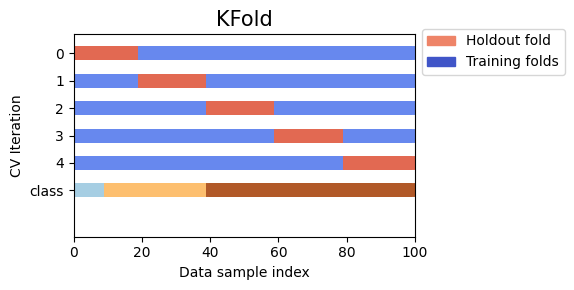

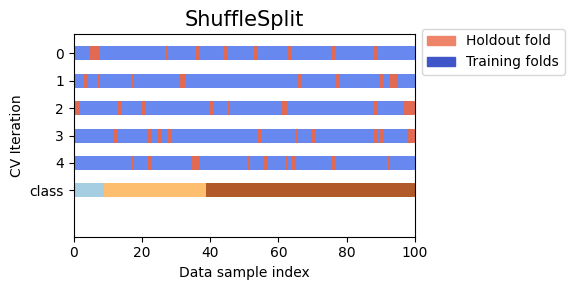

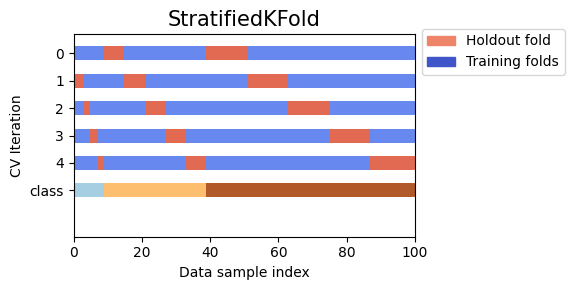

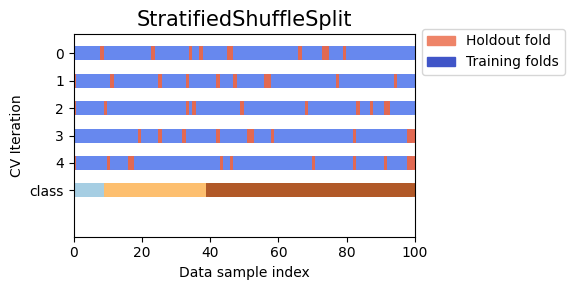

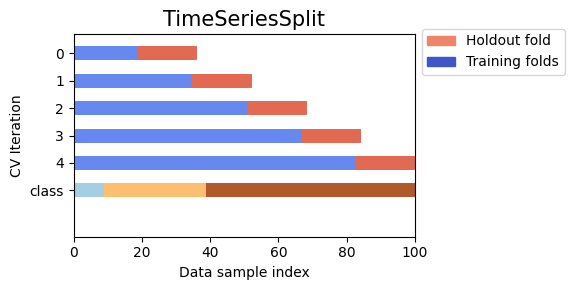

In [256]:
for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Holdout fold", "Training folds" ],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()